# Neural style

* 일단 오리지날 페이퍼
* https://github.com/sjchoi86/Tensorflow-101/blob/master/notebooks/neural_style.ipynb 참고

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib import gridspec

def plot(samples, name=''):
    l = len(samples)
    height = (l+3) // 4
    fig = plt.figure(figsize=(16, height*4))
    gs = gridspec.GridSpec(height, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
#         plt.title(name)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        ax.imshow(sample, cmap='Greys_r')
    
    plt.suptitle(name)
    plt.show()
#     plt.imshow(sample, cmap='Greys_r')

#     return fig

In [3]:
VGG_PATH = 'data/imagenet-vgg-verydeep-19.mat'
CONTENT_PATH = 'data/flash.jpg'
CONTENT_LAYER = 'relu4_2'
STYLE_PATH = 'data/style1.jpg'
STYLE_LAYERS = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

In [4]:
# hyperparams
content_weight = 5
style_weight = 100
tv_weight = 500 # total variational denoising
learning_rate = 5. # 10???

## VGG

* refactoring 필요
    * 최소한 이걸 쓰더라도 원본 (https://github.com/anishathalye/neural-style) 을 갖다쓰는게 나을 듯
    * 단, L-BFGS 는 다른곳에서 가져와야함 (hwalsuk?)
* slim 을 사용해보고 싶은데 어떻게하는지 잘 모르겠음
* slim 외에도 pre-trained VGG 를 가져와서 쓰고 싶은데...

In [5]:
import scipy.io

In [6]:
class VGG:
    def __init__(self, data_path=VGG_PATH):
        self.layers = (
            'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
            'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
            'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
            'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
            'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
            'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
            'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
            'relu5_3', 'conv5_4', 'relu5_4'
        )
        data = scipy.io.loadmat(data_path)
        if not all(i in data for i in ('layers', 'classes', 'normalization')):
            raise ValueError("You're using the wrong VGG19 data. Please follow the instructions in the README to download the correct data.")
        
        mean = data['normalization'][0][0][0]
        self.mean_pixel = np.mean(mean, axis=(0, 1))
        self.weights = data['layers'][0]
    
    def _conv_layer(self, input, weights, bias):
        conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
                padding='SAME')
        return tf.nn.bias_add(conv, bias)


    def _pool_layer(self, input, pooling):
        if pooling == 'avg':
            return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                    padding='SAME')
        else:
            return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                    padding='SAME')

    def preproc(self, image):
        return image - self.mean_pixel

    def unproc(self, image):
        return image + self.mean_pixel
    
    def build_net(self, input_image, pooling='max'):
        net = {}
        current = input_image
        for i, name in enumerate(self.layers):
            kind = name[:4]
            if kind == 'conv':
                kernels, bias = self.weights[i][0][0][0][0]
                # matconvnet: weights are [width, height, in_channels, out_channels]
                # tensorflow: weights are [height, width, in_channels, out_channels]
                kernels = np.transpose(kernels, (1, 0, 2, 3))
                bias = bias.reshape(-1)
                current = self._conv_layer(current, kernels, bias)
            elif kind == 'relu':
                current = tf.nn.relu(current)
            elif kind == 'pool':
                current = self._pool_layer(current, pooling)
            net[name] = current

        assert len(net) == len(self.layers)
        return net

In [7]:
def imread(path):
    return scipy.misc.imread(path)
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)

In [8]:
vgg = VGG()

## Features of content image

Questions:

* 왜 CONTENT_LAYER 가 `relu2_2` 밖에 안되지? 보다 상위 레이어여야 하는거 아닌가?
* 실제로 원본에서는 relu4 와 relu5 를 씀. 두개를 다 쓰는거 같은데 이건 자세히는 더 봐야 알듯

In [9]:
import matplotlib.image as mpimg

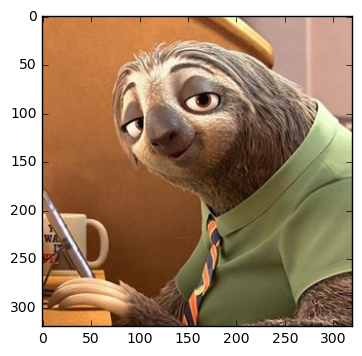

In [10]:
content = imread(CONTENT_PATH)
plt.imshow(content, cmap='jet'); # ; is jupyter magic

In [11]:
content.shape

(320, 320, 3)

In [12]:
content = content.astype(np.float)
content_shape = (1,) + content.shape # (h, w, nch) => (1, h, w, nch)
# nch = rgb?

# 여러개의 그래프를 생성하기 위해 이렇게 하는듯
with tf.Graph().as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=content_shape)
    nets = vgg.build_net(image)
    content_pre = np.array([vgg.preproc(content)]) # (h, w, nch) => (1, h, w, nch)
    content_features = sess.run(nets[CONTENT_LAYER], {image: content_pre})

In [13]:
content_features.shape

(1, 40, 40, 512)

In [13]:
CONTENT_LAYER

'relu4_2'

In [14]:
content_features.shape

(1, 40, 40, 512)

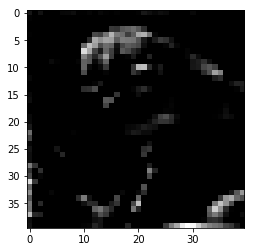

In [15]:
plt.imshow(content_features[0, :, :, 0], cmap='gray');

이건 근데 reconstruction 을 한 게 아니라 feature map 을 그대로 보여준 거니까, 당연히 뭉개지는 것 같은데. 논문에서 보여준거랑은 다른얘기인거 같은데. 뭐 이게 content feature 라고는 할 수 있으려나..

## Features of style image

Q. 아마 content 랑 style 이랑 shape 을 맞춰줘야 했던거 같은데?

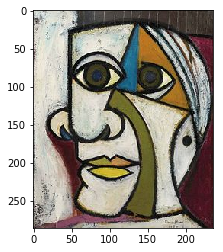

In [16]:
style = imread(STYLE_PATH)
plt.imshow(style);

In [17]:
content.shape, style.shape

((320, 320, 3), (286, 236, 3))

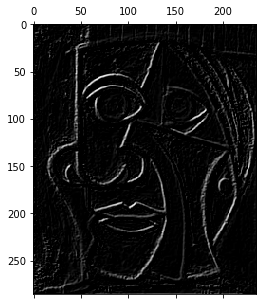

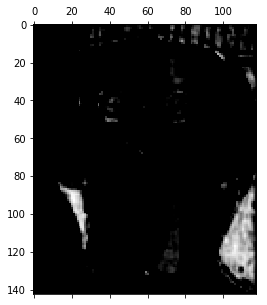

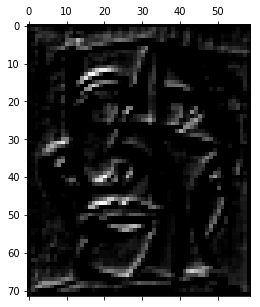

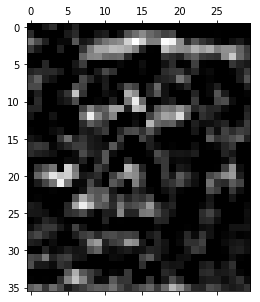

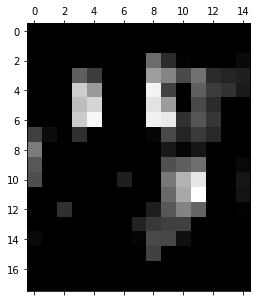

In [18]:
style = style.astype(np.float)
style_shape = (1,) + style.shape
style_features = {}

with tf.Graph().as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=style_shape)
    nets = vgg.build_net(image)
    style_pre = np.array([vgg.preproc(style)]) 
#     feature_x = sess.run(nets, {x: preproc_style})
    for style_layer in STYLE_LAYERS:
        features = sess.run(nets[style_layer], {image: style_pre})
        plt.matshow(features[0, :, :, 0], cmap='gray') # 이게 무슨 의미가 있나... recon 도 아니고... 
        
        features = features.reshape(-1, features.shape[-1]) # 피처맵을 1차원으로 펴줌 (flattern)
        gram = np.matmul(features.T, features) / features.size # 이렇게 사이즈로 나눠주는게 논문에 있던가...
        style_features[style_layer] = gram

## Stylize

일단, 짜고 보자.

In [19]:
def get_tensor_size(tensor):
    from operator import mul
    # d is Dimension class. d.value casts Dim to int
    return reduce(mul, (d.value for d in tensor.shape), 1)

In [20]:
# 요건 tf 에서 새로운 Graph() 를 생성하고 그걸 default 로 지정해주는 작업인 듯.
tf.Graph().as_default()
sess = tf.Session()

In [21]:
initial = tf.random_normal(content_shape) * 0.256
image = tf.Variable(initial_value=initial) # generated image
nets = vgg.build_net(image)

In [22]:
# content loss
content_loss = content_weight * (2 * tf.nn.l2_loss(nets[CONTENT_LAYER] - content_features) / content_features.size)

In [23]:
# style loss
style_losses = []
for style_layer in STYLE_LAYERS:
    layer = nets[style_layer]
    size = get_tensor_size(layer)
    features = tf.reshape(layer, (-1, layer.shape[-1].value))
    gram = tf.matmul(tf.transpose(features), features) / size
    style_gram = style_features[style_layer]
    style_losses.append(2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)

# tensor 가 아니므로 reduce_sum 을 쓸수는 없음...
style_loss = style_weight * reduce(tf.add, style_losses)

In [24]:
# total variation denoising
tv_y_size = get_tensor_size(image[:,1:,:,:])
tv_x_size = get_tensor_size(image[:,:,1:,:])
tv_loss = tv_weight * 2 * (
    (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:content_shape[1]-1,:,:]) / tv_y_size) +
    (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:content_shape[2]-1,:]) / tv_x_size)
)

In [25]:
# overall loss
loss = content_loss + style_loss + tv_loss

[0/1000]
143842032.0 = 2655431.25 + 141157824.0 + 28783.6542969


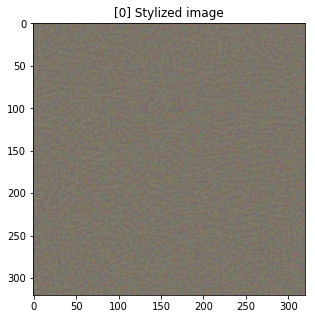

[100/1000]
6294046.5 = 3583697.5 + 1887234.125 + 823115.0


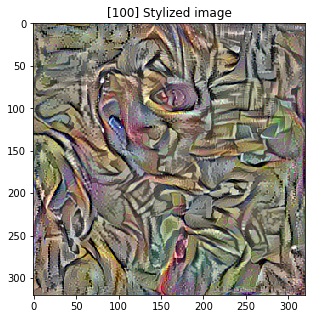

[200/1000]
4474124.5 = 2688933.5 + 1098965.875 + 686225.0


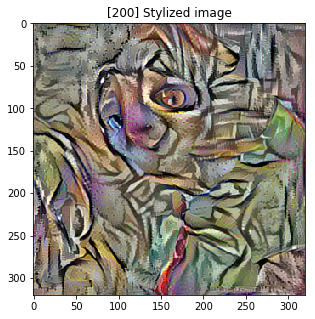

[300/1000]
3786017.25 = 2272019.0 + 879935.375 + 634062.75


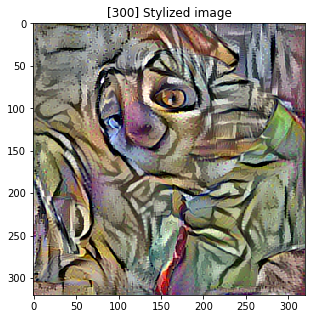

[400/1000]
3419432.0 = 2041623.75 + 773221.75 + 604586.4375


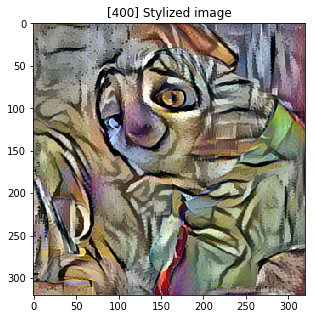

[500/1000]
3195464.5 = 1892584.5 + 719603.4375 + 583276.625


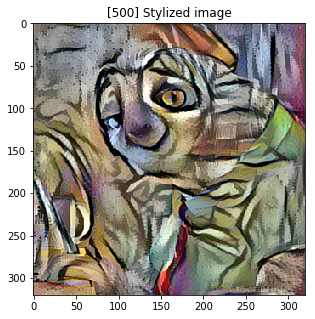

[600/1000]
3035934.5 = 1797307.25 + 669208.625 + 569418.5625


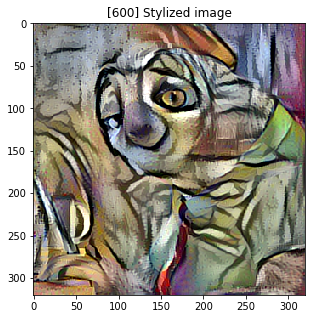

[700/1000]
2936610.75 = 1731535.0 + 646332.5625 + 558743.3125


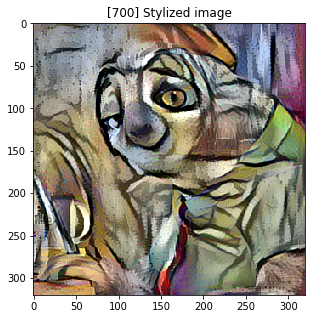

[800/1000]
2856528.0 = 1669434.5 + 636334.4375 + 550759.125


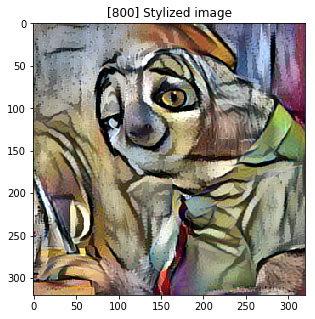

[900/1000]
2829296.0 = 1632856.875 + 650749.5625 + 545689.5625


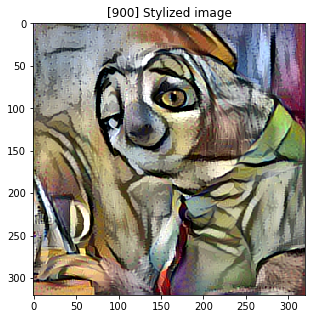

[999/1000]
2731933.25 = 1599830.625 + 593298.375 + 538804.1875


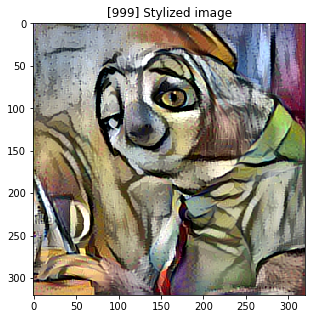

In [26]:
# optimization (originally L-BFGS on paper)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

max_iter = 1000

for i in range(max_iter):
    sess.run(train_op)
    if i % 100 == 0 or i == max_iter-1:
        print ("[%d/%d]" % (i, max_iter))
        out, cur_content_loss, cur_style_loss, cur_tv_loss, cur_loss = sess.run([image, content_loss, style_loss, tv_loss, loss])
        print("{} = {} + {} + {}".format(cur_loss, cur_content_loss, cur_style_loss, cur_tv_loss))
        # Plot
        stylized_img = out[0, :, :, :] + vgg.mean_pixel
        stylized_img = np.clip(stylized_img, 0, 255).astype('uint8')
        plt.figure(0, figsize=(10, 5))
        plt.imshow(stylized_img)
        plt.title("[%d] Stylized image" % (i))
        plt.show()

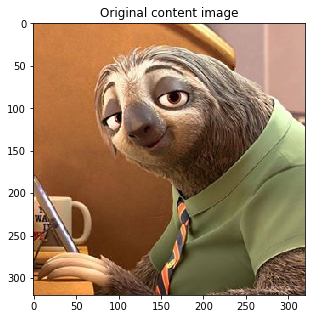

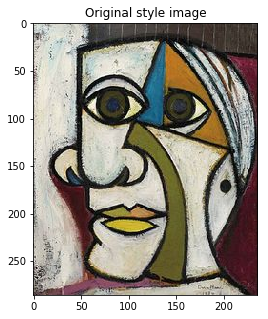

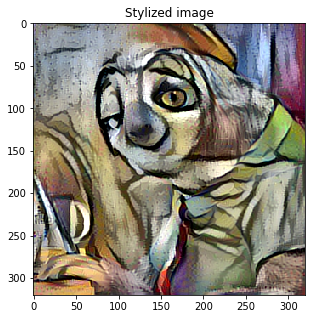

In [27]:
plt.figure(0, figsize=(10, 5))
plt.imshow(content.astype(np.uint8))
plt.title("Original content image")
plt.show()

plt.figure(0, figsize=(10, 5))
plt.imshow(style.astype(np.uint8))
plt.title("Original style image")
plt.show()

stylized_img = out[0, :, :, :] + vgg.mean_pixel
stylized_img = np.clip(stylized_img, 0, 255).astype('uint8')
plt.figure(1, figsize=(10, 5))
plt.imshow(stylized_img)
plt.title("Stylized image")
plt.show()